In [7]:
!pip install  -r requirements.txt


  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
You should consider upgrading via the '/Users/rafael/PycharmProjects/etherscan/venv/bin/python3 -m pip install --upgrade pip' command.


In [8]:
!pip install imbalanced-learn==0.7.0 scikit-learn==0.23.2

You should consider upgrading via the '/Users/rafael/PycharmProjects/etherscan/venv/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import json, requests
import argparse
import sys
import csv
import datetime, dateutil.parser

# lienar algebra library

import pandas as pd
import time
import re
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline


In [11]:
data = pd.read_excel('data_ethereum_ponzi_2018.xlsx', index_col=0)

In [12]:
data.head()

,Name,Address,In Tx,Out Tx,In ETH,Out ETH,In USD,Out USD,Paying,Paid,Date 1st Tx,Date last Tx,Lifetime,Sources,Type
Id,,,,,,,,,,,,,,,
1,Government,0xf45717552f12ef7cb65e95476f217ea008167ae3,723.0,846.0,2.938886e+07,2.938886e+07,35.738,"$40,066.24",40.0,27.0,2016-03-08,2017-03-20,377.0,NaN,Ponzi
2,EthereumPyramid,0x7011f3edc7fa43c81440f9f43a6458174113b162,978.0,339.0,9.860812e+09,9.167812e+09,5.044,"$5,290.46",327.0,125.0,2015-09-07,2018-04-11,947.0,NaN,Ponzi
3,ProtectTheCastle2,0x7d56485e026d5d3881f778e99969d2b1f90c50af,890.0,1257.0,1.332225e+08,1.332225e+08,186.04,"$190,802.38",101.0,68.0,2016-03-20,2018-02-22,704.0,NaN,Ponzi
4,TreasureChest,0x4865e85c72a27ca6c362da75ba6707c07464b953,73.0,1197.0,8.755649e+09,8.738955e+09,946,$940.82,16.0,10.0,2016-03-26,2016-04-07,12.0,NaN,Ponzi
5,ZeroPonzi,0x43bbc7fafb860d974037b8f7dd06b6f6fe799b3e,627.0,499.0,4.489784e+09,4.489177e+09,49.816,"$49,770.97",47.0,28.0,2016-04-04,2017-10-27,571.0,NaN,Ponzi


In [13]:
data.shape

(1819, 15)

In [15]:

data_path = "ehterumOpcodes_datset.xlsx"
data = pd.read_excel(data_path, engine='openpyxl')

# Check if the 'opcodes' column is present
if 'opcodes' in data.columns:
    text_feat = data['opcodes'].copy()
else:
    print("The column 'opcodes' doesn't exist in the provided spreadsheet.")

In [16]:
data.head()

,Id,Name,Address,In Tx,Out Tx,In ETH,Out ETH,In USD,Out USD,Paying,Paid,Date 1st Tx,Date last Tx,Lifetime,Sources,Type,opcodes
0,1,Government,0xf45717552f12ef7cb65e95476f217ea008167ae3,723.0,846.0,2.938886e+07,2.938886e+07,35.738,"$40,066.24",40.0,27.0,2016-03-08,2017-03-20,377.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
1,2,EthereumPyramid,0x7011f3edc7fa43c81440f9f43a6458174113b162,978.0,339.0,9.860812e+09,9.167812e+09,5.044,"$5,290.46",327.0,125.0,2015-09-07,2018-04-11,947.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
2,3,ProtectTheCastle2,0x7d56485e026d5d3881f778e99969d2b1f90c50af,890.0,1257.0,1.332225e+08,1.332225e+08,186.04,"$190,802.38",101.0,68.0,2016-03-20,2018-02-22,704.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
3,4,TreasureChest,0x4865e85c72a27ca6c362da75ba6707c07464b953,73.0,1197.0,8.755649e+09,8.738955e+09,946,$940.82,16.0,10.0,2016-03-26,2016-04-07,12.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
4,5,ZeroPonzi,0x43bbc7fafb860d974037b8f7dd06b6f6fe799b3e,627.0,499.0,4.489784e+09,4.489177e+09,49.816,"$49,770.97",47.0,28.0,2016-04-04,2017-10-27,571.0,NaN,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...


In [17]:
data.groupby('Type').describe()

Id                                                              \
        count    mean         std    min     25%     50%      75%     max   
Type                                                                        
Legal  1635.0  1002.0  472.128161  185.0  593.50  1002.0  1410.50  1819.0   
Ponzi   184.0    92.5   53.260367    1.0   46.75    92.5   138.25   184.0   

       In Tx             ... Lifetime         Sources                       \
       count       mean  ...      75%     max   count mean std min 25% 50%   
Type                     ...                                                 
Legal    0.0        NaN  ...      NaN     NaN     0.0  NaN NaN NaN NaN NaN   
Ponzi  184.0  99.429348  ...    533.5  1050.0     0.0  NaN NaN NaN NaN NaN   

               
      75% max  
Type           
Legal NaN NaN  
Ponzi NaN NaN  

[2 rows x 72 columns]

In [18]:
data_filtered = pd.concat([data['Type'], data['opcodes']], axis=1)

In [19]:
data_filtered.head()

,Type,opcodes
0,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
1,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
2,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
3,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
4,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...


In [20]:
data_filtered.groupby('Type').describe()

opcodes                                                               
        count unique                                                top freq
Type                                                                        
Legal    1632   1173          PUSH1 PUSH1 MSTORE PUSH1 DUP1 REVERT STOP   86
Ponzi     184    147  PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...    5

In [21]:
data_filtered['opcodes']

0       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
1       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
2       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
3       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
4       PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
                              ...                        
1815    PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
1816    PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
1817    PUSH1 PUSH1 MSTORE CALLVALUE DUP1 ISZERO PUSH2...
1818                                                  NaN
1819    PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
Name: opcodes, Length: 1820, dtype: object

In [22]:
#Let's remove some empty contracts (has been removed from etherscan)!!!
data_filtered = data_filtered[data_filtered['opcodes'].apply(isinstance, args=(str,))]


In [25]:
data_filtered['length'] = data_filtered['opcodes'].apply(len)


In [26]:
data_filtered.head()

,Type,opcodes,length
0,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,10857
1,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,9441
2,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,6189
3,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,2859
4,Ponzi,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...,32767


array([<AxesSubplot:title={'center':'Legal'}>,
       <AxesSubplot:title={'center':'Ponzi'}>], dtype=object)

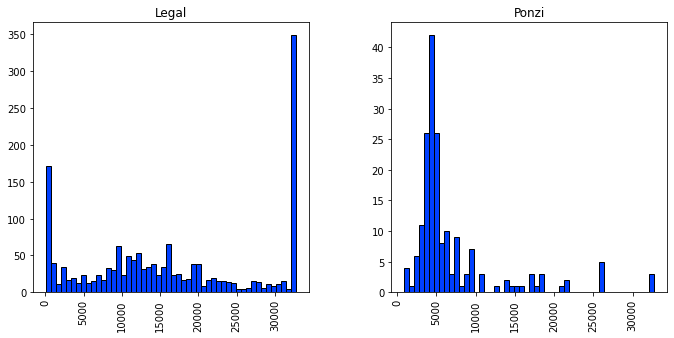

In [27]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
data_filtered.hist(column='length', by='Type', bins=50,figsize=(11,5))

In [28]:
text_feat = data_filtered['opcodes'].copy()

In [29]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    #text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    #TODO:implement stopwords list for some special cases
    text = [word for word in text.split()]
    return " ".join(text)

In [34]:
#vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(tokenizer=str.split, ngram_range=(1, 3))
features = vectorizer.fit_transform(text_feat)
#ngram_tfidf_matrix = vectorizer_ngram.fit_transform(data_filtered['opcodes'])

In [35]:
data_filtered = data_filtered.dropna(subset=['Type'])
features = vectorizer.fit_transform(data_filtered['opcodes'])

In [36]:
#En primer lugar, dividamos nuestras funciones para probar y entrenar el conjunto 

features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    data_filtered['Type'], 
    test_size=0.3, 
    random_state=111, 
    stratify=data_filtered['Type']
)

In [37]:
#Ahora importemos un montón de clasificadores, inicialícelos y creemos un diccionario para iterar

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity


Parametres are based on notebook: Spam detection Classifiers hyperparameter tuning
https://www.kaggle.com/code/muzzzdy/spam-detection-classifiers-hyperparameter-tuning?scriptVersionId=0

In [38]:
#Parametres are based on notebook: Spam detection Classifiers hyperparameter tuning
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [39]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}


In [40]:
#Hagamos funciones que se ajusten a nuestros clasificadores y hagamos predicciones
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

def predict_labels(clf, features):
    return (clf.predict(features))  

In [43]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [44]:
pred_scores

[('SVC', [0.9963302752293578]),
 ('KN', [0.9798165137614679]),
 ('NB', [0.9688073394495413]),
 ('DT', [0.998165137614679]),
 ('LR', [0.9853211009174312]),
 ('RF', [0.9926605504587156]),
 ('AdaBoost', [0.998165137614679]),
 ('BgC', [0.9963302752293578]),
 ('ETC', [0.9944954128440368])]

In [62]:
df = pd.DataFrame.from_records(pred_scores, index='', columns=[ '', 'Score'])
df

,,Score
,,
SVC,SVC,[0.9963302752293578]
KN,KN,[0.9798165137614679]
NB,NB,[0.9688073394495413]
DT,DT,[0.998165137614679]
LR,LR,[0.9853211009174312]
RF,RF,[0.9926605504587156]
AdaBoost,AdaBoost,[0.998165137614679]
BgC,BgC,[0.9963302752293578]
ETC,ETC,[0.9944954128440368]


In [63]:
print(df.dtypes)


         object
Score    object
dtype: object


In [64]:
df['Score'] = df['Score'].apply(lambda x: x[0])


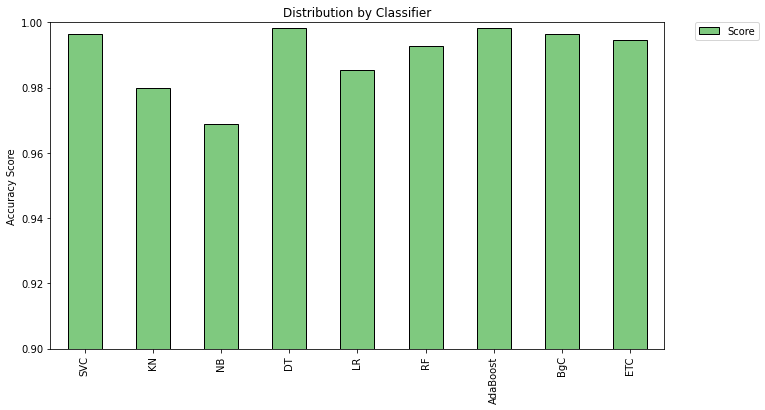

In [65]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)